In [97]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score

In [84]:
CONTENT_DIR = "contents"
TOTAL_WEBSITES = 97

We imported some libraries we are going to use and also we set up some constants

In [3]:
def file_into_words(file_name):
    file = open(CONTENT_DIR + "/" + file_name, "r", encoding="utf8")
    only_letters = [''.join(filter(str.isalpha, s)) for s in file.read().split(" ")]
    no_empty = list(filter(None, only_letters))
    return set(map(str.lower, no_empty))

_file_into_words_ will receive a file name and will read its contents, returning a set of all its words, removing the words that containt any number. We can also clean it even more, **doing some stemming and lemmatization**.

In [4]:
words = {}
websites_dir = {}
i = 0
for file in os.listdir(CONTENT_DIR):
    websites_dir[i] = file
    i += 1
    words[file] = file_into_words(file)

In [5]:
def score(a, b):
    return len(a & b)/len(a.union(b))

This _score_ function will return a score, given two sets of words. A higher score means the sets are more similar since they share more words with each other.

In [6]:
distance_matrix = []

In [7]:
dist = lambda p1, p2: score(p1,p2)
distance_matrix = np.asarray([[score(p1, p2) for p2 in words.values()] for p1 in words.values()])

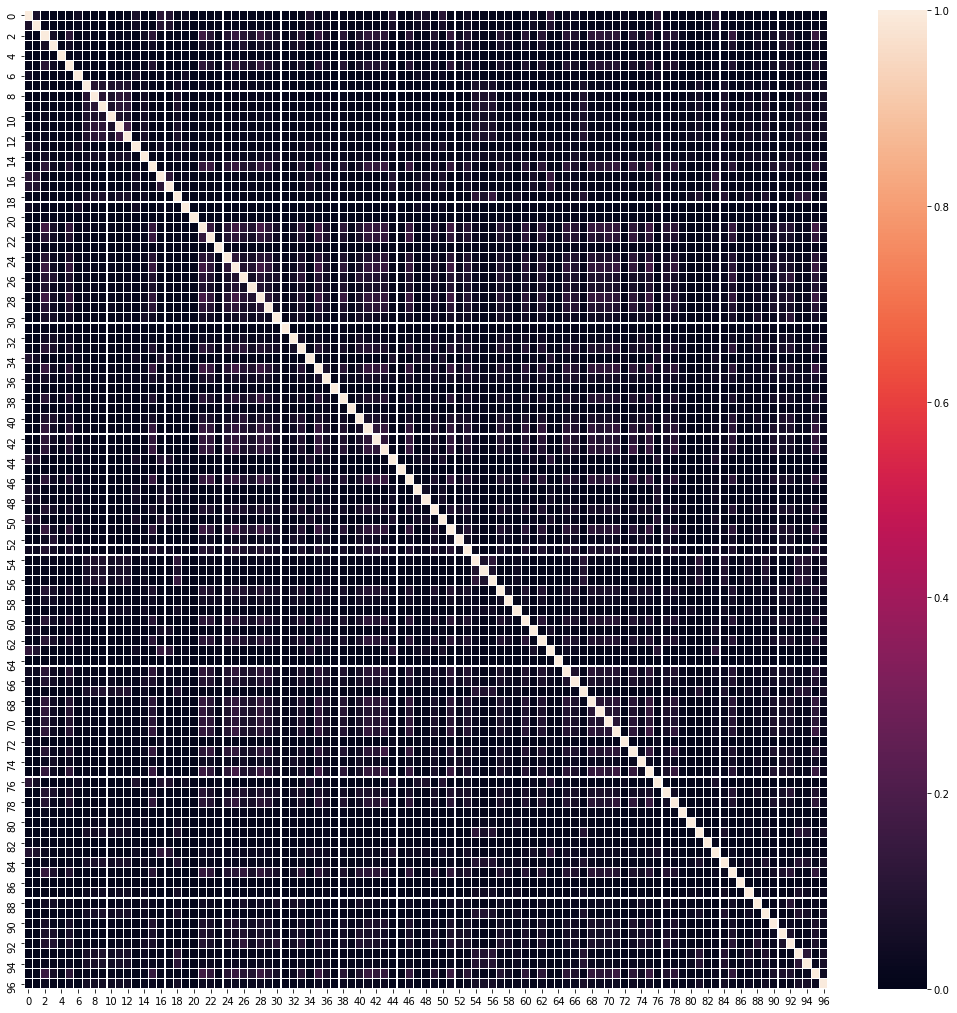

In [138]:
plt.rcParams['figure.figsize'] = [18, 18]
ax = sns.heatmap(distance_matrix, linewidth=0.1)
plt.show()

This heatmap shows the pairwise score between each website. Almost most of them, as we can see with the raw data below, have a low score. It is obvious that the elements of the diagonal are 1 since we are comparing the same set twice. We will normalize this matrix between 0 and 1, and then invert it, so we can have a distance matrix (most similar sets will be closer to 0, and most different will be closest to 1).

In [9]:
distance_matrix

array([[1.        , 0.06828303, 0.00920543, ..., 0.00696481, 0.00674049,
        0.00617615],
       [0.06828303, 1.        , 0.01173959, ..., 0.00400687, 0.01027276,
        0.00400891],
       [0.00920543, 0.01173959, 1.        , ..., 0.02600897, 0.15043514,
        0.03141727],
       ...,
       [0.00696481, 0.00400687, 0.02600897, ..., 1.        , 0.02411432,
        0.06366103],
       [0.00674049, 0.01027276, 0.15043514, ..., 0.02411432, 1.        ,
        0.0361727 ],
       [0.00617615, 0.00400891, 0.03141727, ..., 0.06366103, 0.0361727 ,
        1.        ]])

In [10]:
max_not_one = np.max(np.where(distance_matrix==1,-1,distance_matrix))

In [11]:
distance_matrix_2 = np.where(distance_matrix==1,max_not_one,distance_matrix)

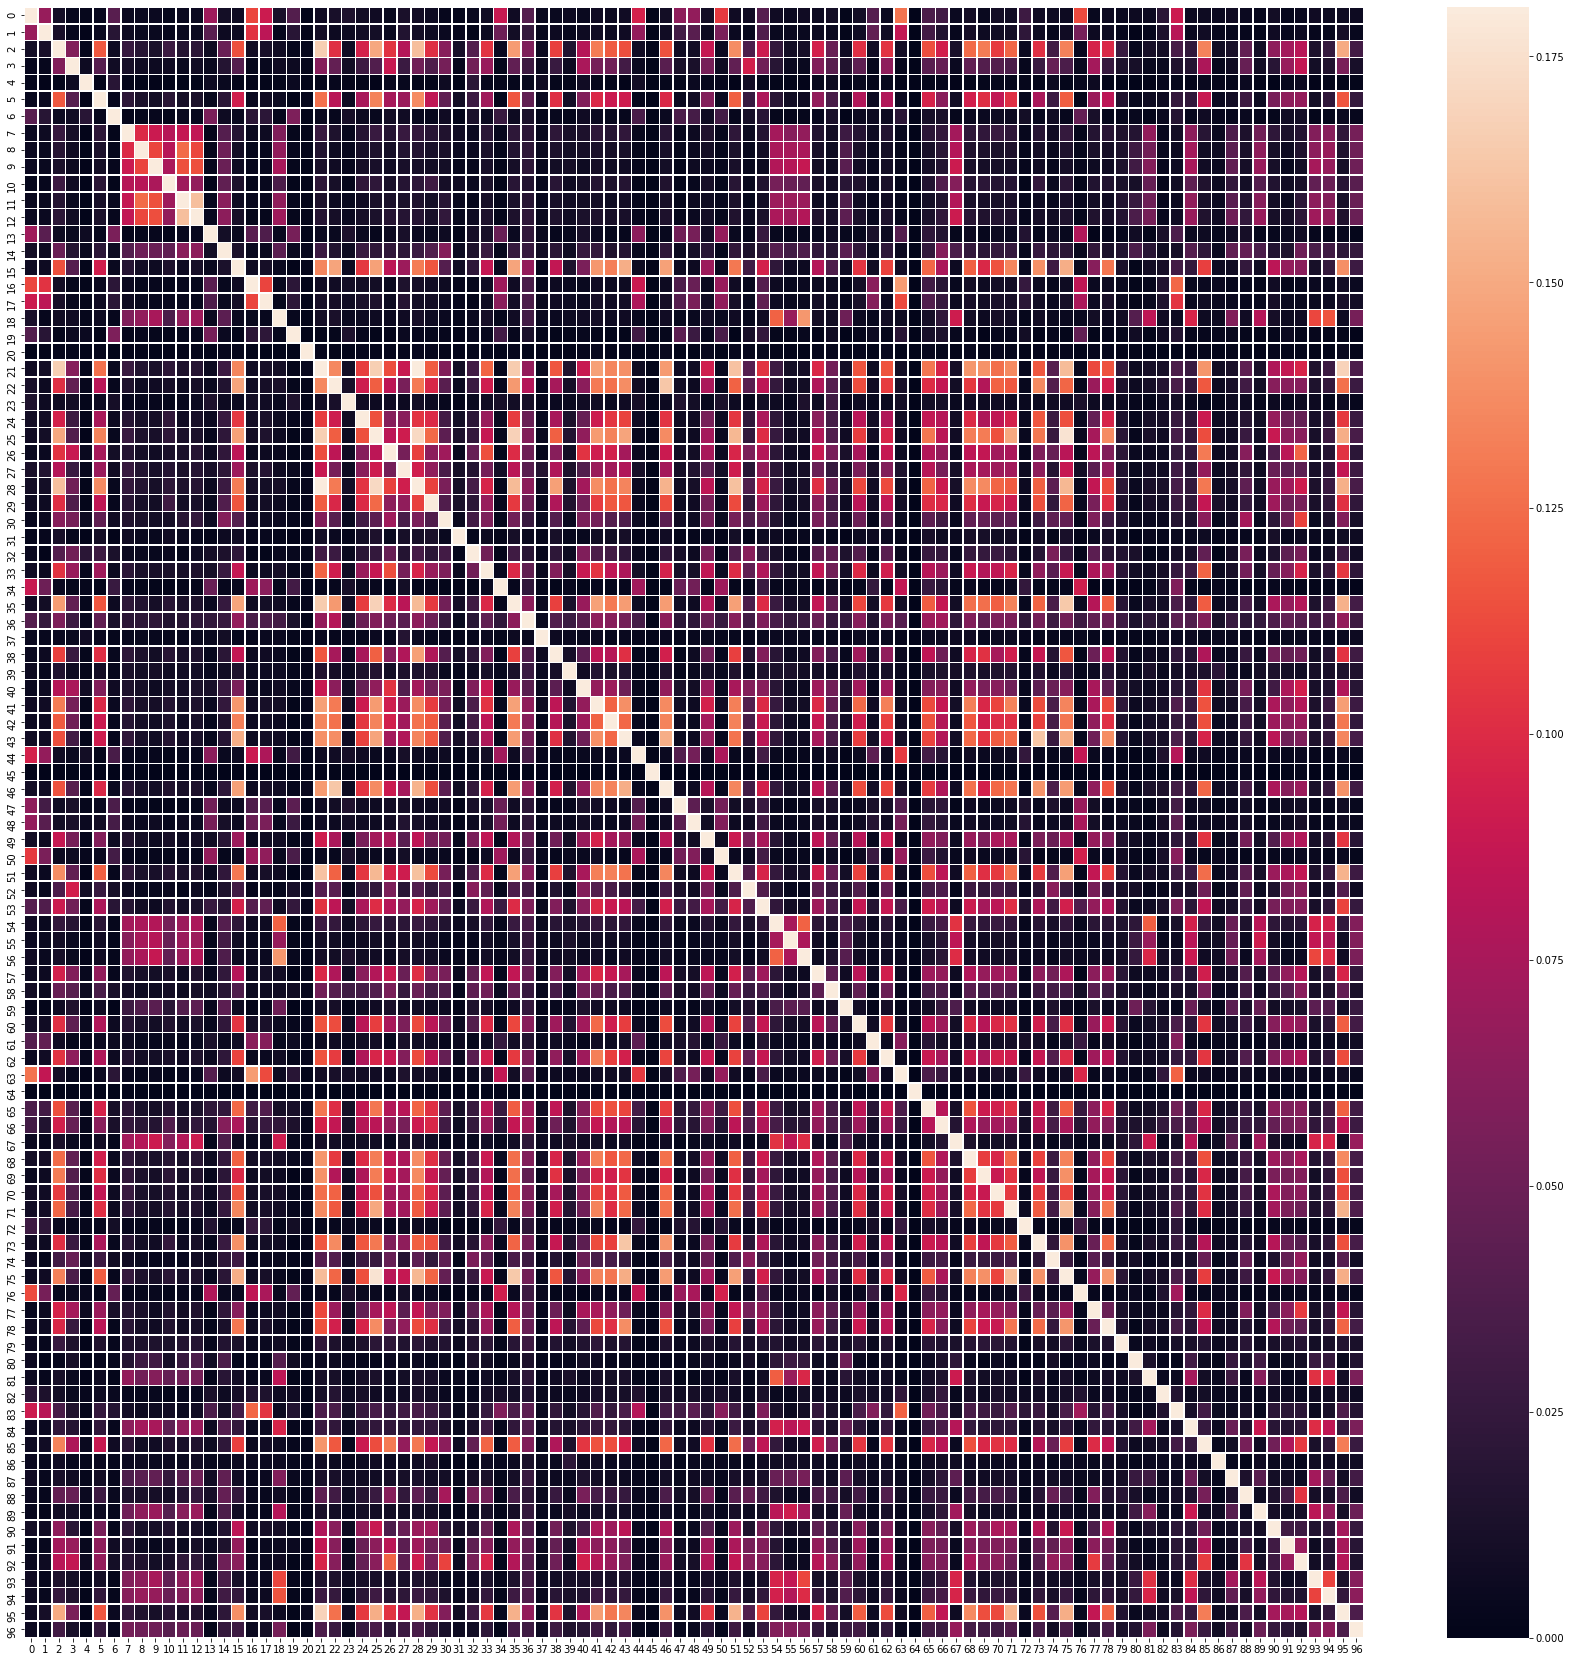

In [12]:
plt.rcParams['figure.figsize'] = [30, 30]
ax = sns.heatmap(distance_matrix_2, linewidth=0.5)
plt.show()

In [13]:
distance_matrix_2 /= np.max(np.abs(distance_matrix_2), axis=0)
distances = np.abs(1-distance_matrix_2)

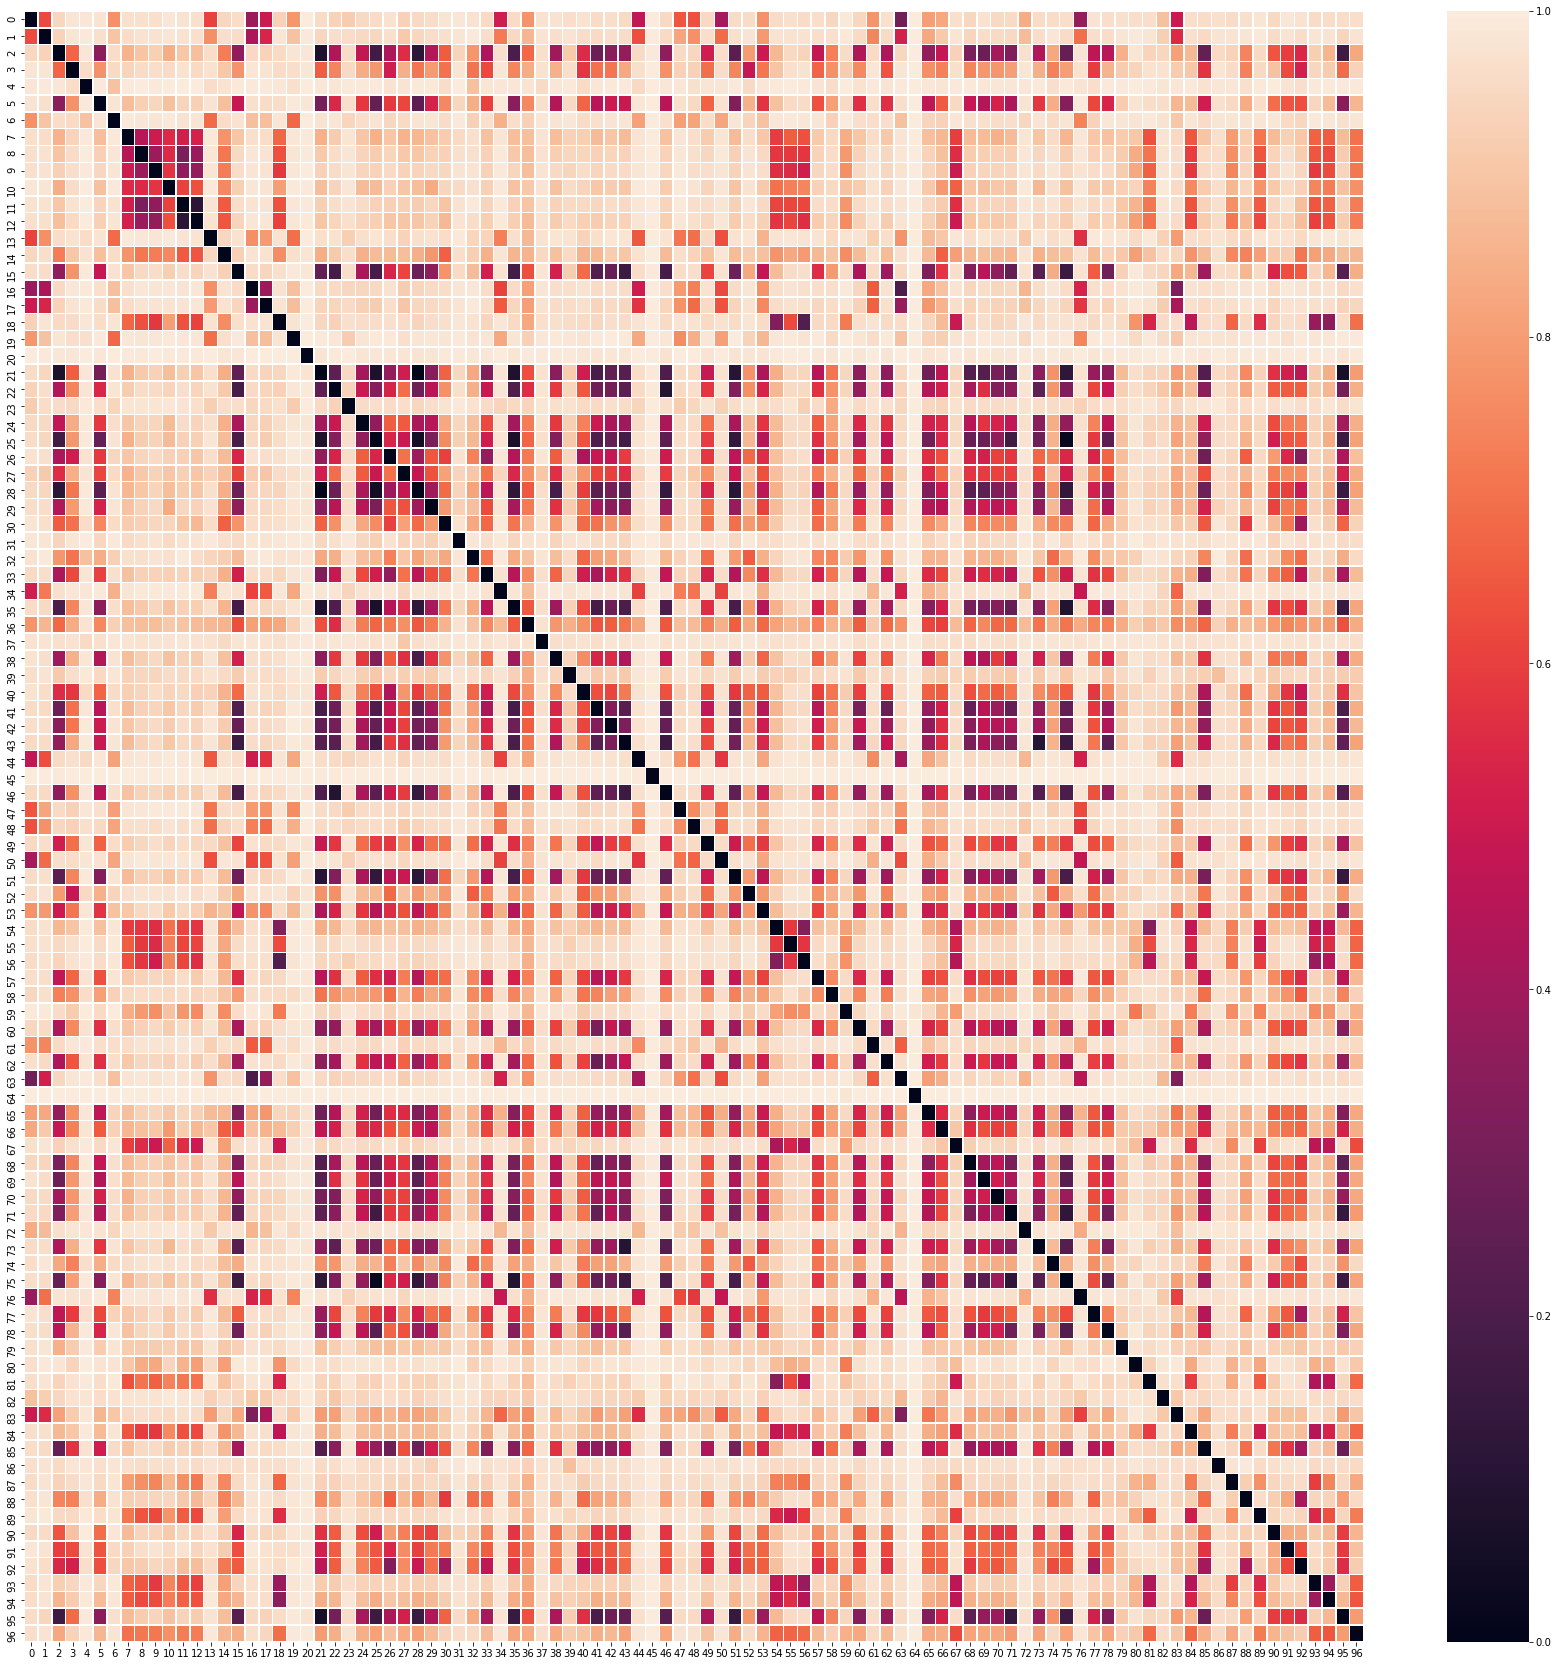

In [14]:
plt.rcParams['figure.figsize'] = [30, 30]
ax = sns.heatmap(distances, linewidth=0.5)
plt.show()

At this point, **distance** is our distance matrix. As we mentioned before, the diagonal is [0, ..., 0] because is a distance matrix. We can see some clustering already happening.

To create the clusters themselves, we are going to set a cutoff limit, and group the websites that are at a distance lower than this cutoff. If ```cutoff = X```, and website A and B are closer than X, then they will belong to the same cluster. If then B and C are also closer than X, then A, B and C will belong to the same cluster. This is a recursive way to group websites according to its distance.

We will see what happens with different value for the cutoff and the different clusters that are generated.

In [100]:
def cluster_by_cutoff(matrix, cutoff):
    X = [[i, j, matrix[i,j]] for j in range(matrix.shape[1]) for i in range(matrix.shape[0]) if i > j]
    X.sort(key=lambda d: float(d[2]))
    singles = set([ id1 for id1, id2, distance in X ] + [ id2 for id1, id2, distance in X ])
    dimers = [ set([id1, id2]) for id1, id2, distance in X if float(distance) < cutoff ]
    clusters = deepcopy(dimers)
    joined = True
    while joined:
        joined = False
        i=0
        while i < len(clusters):
            j=i+1
            while j < len(clusters):
                if len(clusters[i] & clusters[j])>0:
                    clusters[i] |= clusters[j]
                    clusters.remove(clusters[j])
                    joined = True
                else:
                    j+=1
            i+=1
    single_clusters = singles - set([item for subset in clusters for item in subset])

    labels = [0]*97
    i = 1
    for c in clusters:
        for site in c:
            labels[site] = i

    return clusters, single_clusters, labels

def print_clusters(clusters):
    c = 1
    for cluster in clusters:
        print(c, len(cluster))
        cl = list(map(lambda x: websites_dir[x], cluster))
        print(", ".join(cl))
        c += 1

In [112]:
clusters30, _, labels30 = cluster_by_cutoff(distances, 0.3)
print_clusters(clusters30)

1 25
www.jowat.com, bombayoilseals.com, www.klinger-international.com, www.laxmirubberindustries.com, buffalofelt.com, www.maxnovomachine.com, www.millerwelds.com, www.miprcorp.com, www.palmermfg.com, hbc-system.com, pristinevincork.wordpress.com, smabbler.com, www.sankar.com, www.acoustafoam.com, www.adityaautomotiveinc-india.com, www.afgco.com, www.zdpwolow.pl, www.aquasealrubber.co.uk, www.auburn-mfg.com, www.besseges-vtf.co.uk, www.bostik.com, www.briskheat.com, www.cometic.com, www.gasketeng.com, www.industrialbearings.com.au
2 2
de.rilsonindustry.com, de.techoseal.com
3 3
lama.es, achedosol.com, www.iridoi.com
4 2
www.heckerwerke.de, mikro-technik.com


In [113]:
clusters40, _, labels40 = cluster_by_cutoff(distances, 0.4)
print_clusters(clusters40)

1 34
www.jowat.com, bombayoilseals.com, www.klinger-international.com, www.laxmirubberindustries.com, buffalofelt.com, www.maxnovomachine.com, www.manufacturers.com.tw, www.millerwelds.com, www.miprcorp.com, www.nationalcorksheetco.com, www.palmermfg.com, hbc-system.com, pristinevincork.wordpress.com, smabbler.com, www.sankar.com, www.3dsystems.com, www.acoustafoam.com, www.adityaautomotiveinc-india.com, www.afgco.com, www.ahlstrom-munksjo.com, www.synthetic-fiber-sheet.com, www.zdpwolow.pl, www.aiflon.com, www.ansintl.com, www.aquasealrubber.co.uk, www.auburn-mfg.com, www.besseges-vtf.co.uk, www.bostik.com, www.briskheat.com, www.cometic.com, www.gasketeng.com, www.grip-on.com, www.hyspecs.co.nz, www.industrialbearings.com.au
2 4
de.foam-silicone.com, de.jointeflons.com, de.rilsonindustry.com, de.techoseal.com
3 6
lama.es, achedosol.com, lumaquin.com, www.sabo-esp.com, www.motritools.com, www.iridoi.com
4 6
www.reinz-industrial.com, mikro-technik.com, www.gummigoetz.de, www.heckerwerk

In [114]:
clusters50, _, labels50 = cluster_by_cutoff(distances, 0.5)
print_clusters(clusters50)

1 40
bombayoilseals.com, buffalofelt.com, hbc-system.com, pristinevincork.wordpress.com, smabbler.com, www.3dsystems.com, www.acoustafoam.com, www.adityaautomotiveinc-india.com, www.aerchs.com, www.afgco.com, www.ahlstrom-munksjo.com, www.aiflon.com, www.ansintl.com, www.aquasealrubber.co.uk, www.auburn-mfg.com, www.bancoindia.com, www.besseges-vtf.co.uk, www.bostik.com, www.briskheat.com, www.cometic.com, www.durrie.com, www.gasketeng.com, www.grip-on.com, www.hernon.com, www.hyspecs.co.nz, www.industrialbearings.com.au, www.jowat.com, www.kartelllabware.com, www.klinger-international.com, www.laxmirubberindustries.com, www.manufacturers.com.tw, www.maxnovomachine.com, www.millerwelds.com, www.miprcorp.com, www.nationalcorksheetco.com, www.palmermfg.com, www.sankar.com, www.sealing-material.com, www.synthetic-fiber-sheet.com, www.zdpwolow.pl
2 13
www.klinger-awschultze.de, de.chinaomen.com, de.foam-silicone.com, de.jointeflons.com, de.rilsonindustry.com, de.techoseal.com, www.reinz-in

In [115]:
clusters55, _, labels55 = cluster_by_cutoff(distances, 0.55)
print_clusters(clusters55)

1 44
bombayoilseals.com, bootsindia.com, buffalofelt.com, hbc-system.com, pristinevincork.wordpress.com, smabbler.com, www.3dsystems.com, www.acoustafoam.com, www.adityaautomotiveinc-india.com, www.aerchs.com, www.afgco.com, www.ahlstrom-munksjo.com, www.aiflon.com, www.ansintl.com, www.aquasealrubber.co.uk, www.auburn-mfg.com, www.bancoindia.com, www.besseges-vtf.co.uk, www.bostik.com, www.briskheat.com, www.cometic.com, www.durrie.com, www.gasketeng.com, www.gre.es, www.grip-on.com, www.hernon.com, www.hyspecs.co.nz, www.industrialbearings.com.au, www.jowat.com, www.kartelllabware.com, www.klinger-international.com, www.laxmirubberindustries.com, www.manufacturers.com.tw, www.maxnovomachine.com, www.millerwelds.com, www.miprcorp.com, www.nationalcorksheetco.com, www.palmermfg.com, www.sankar.com, www.sealing-material.com, www.suppliersof.com, www.sweere.net, www.synthetic-fiber-sheet.com, www.zdpwolow.pl
2 15
www.klinger-awschultze.de, de.chinaomen.com, de.foam-silicone.com, de.joint

In [117]:
clusters60, _, labels60 = cluster_by_cutoff(distances, 0.6)
print_clusters(clusters60)

1 45
bombayoilseals.com, bootsindia.com, buffalofelt.com, hbc-system.com, pristinevincork.wordpress.com, smabbler.com, www.3dsystems.com, www.acoustafoam.com, www.adityaautomotiveinc-india.com, www.aerchs.com, www.afgco.com, www.ahlstrom-munksjo.com, www.aiflon.com, www.ansintl.com, www.aquasealrubber.co.uk, www.arburg.com, www.auburn-mfg.com, www.bancoindia.com, www.besseges-vtf.co.uk, www.bostik.com, www.briskheat.com, www.cometic.com, www.durrie.com, www.gasketeng.com, www.gre.es, www.grip-on.com, www.hernon.com, www.hyspecs.co.nz, www.industrialbearings.com.au, www.jowat.com, www.kartelllabware.com, www.klinger-international.com, www.laxmirubberindustries.com, www.manufacturers.com.tw, www.maxnovomachine.com, www.millerwelds.com, www.miprcorp.com, www.nationalcorksheetco.com, www.palmermfg.com, www.sankar.com, www.sealing-material.com, www.suppliersof.com, www.sweere.net, www.synthetic-fiber-sheet.com, www.zdpwolow.pl
2 17
www.klinger-awschultze.de, de.chinaomen.com, de.foam-silico

In [119]:
clusters70, _, labels70 = cluster_by_cutoff(distances, 0.7)
print_clusters(clusters70)

1 83
achedosol.com, barrocorestaurante.mx, bombayoilseals.com, bootsindia.com, buffalofelt.com, colorsystemcar.com, de.chinaomen.com, de.foam-silicone.com, de.jointeflons.com, de.plasticptfe.com, de.rilsonindustry.com, de.techoseal.com, elcomair.es, german.aiflon.com, hbc-system.com, lama.es, lumaquin.com, mikro-technik.com, piher.com, pristinevincork.wordpress.com, smabbler.com, www.3dsystems.com, www.acoustafoam.com, www.adityaautomotiveinc-india.com, www.aerchs.com, www.afgco.com, www.ahlstrom-munksjo.com, www.aiflon.com, www.airengr.com, www.ansintl.com, www.apimex.org, www.aquasealrubber.co.uk, www.arburg.com, www.auburn-mfg.com, www.bancoindia.com, www.besseges-vtf.co.uk, www.bostik.com, www.briskheat.com, www.chesterton.cl, www.cometic.com, www.criscarreira.com, www.degso.com, www.durrie.com, www.fluival.com, www.gasketeng.com, www.gre.es, www.grip-on.com, www.gummigoetz.de, www.h-t-w.at, www.heckerwerke.de, www.hernon.com, www.hitechseals.com, www.hyspecs.co.nz, www.ictsl.net, 

As we can see, different clusters are generated with different cutoff values. For a cutoff = 0.7, there is only one cluster, so we can discard it.

For values of cuttoff below 0.5, the clusters generated don't have too many websites. Almost 2/3 of the websites are ignored and don't belong to any clusters. It seems the best ones are the clusters generated with cutoff 0.5, 0.55 and 0.6.

If we pay attention to them, we can see the websites have been clustered based on their language. The three of them **recognized and clustered the websites based on 3 main languages: English, German and Spanish**. However, with a cutoff of 0.5, it created two more clusters, wrongly separating two English websites into a new and fourth cluster, and two German websites into a fifth cluster (it is interesting to note, thought, that this fifth cluster has two websites from Austria, so maybe it detected a different dialect of German spoke at Austria?)

To check which of these three clusterings are better, we will see their Silhouette score.


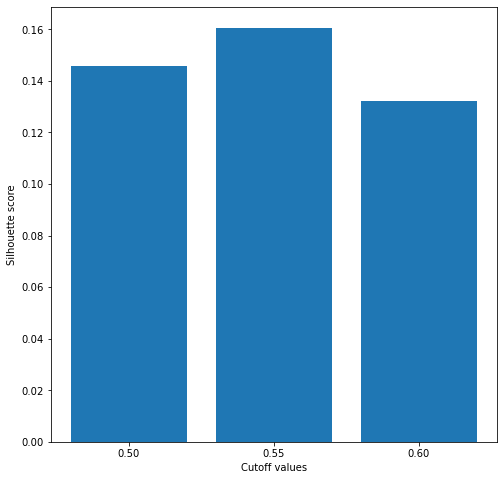

In [145]:
sc50 = silhouette_score(distances, labels50)
sc55 = silhouette_score(distances, labels55)
sc60 = silhouette_score(distances, labels60)

plt.rcParams['figure.figsize'] = [8, 8]
_, ax = plt.subplots()
ax.bar(["0.50", "0.55", "0.60"],[sc50, sc55, sc60])
ax.set_ylabel("Silhouette score")
ax.set_xlabel("Cutoff values")
plt.show()

However, although 0.55 as a cutoff value returns  better Silhouette score, using 0.6 as a cutoff can return better results, if we check the data manually. While it is true that the amount of clusters is the same in both cases (three clusters), when using a cutoff of 0.6 the amount of websites is larger, which means more websites are considered and identified correctly.

## Improvements

The clustering has a lot of room for improvements, as the results can show. Choosing the cutoff 0.6, we are clustering 74 websites, leaving out 23 websites. This is something to consider.

There is a lot of improvement in the first part of the clustering: how to retrieve words from the file and then assigning a score to the relationship between two websites.

As we mentioned before, it could be possible to do some stemming and lemmatization. Also, cleaning some words that aren't specific to any language, as the labels _EN_, _ES_, _IT_, _DE_, for example, that appear in the language navigation. Same applies to other words.

The _score_ function is also very basic, and although it seems to work, it'd be interesting to play with it to see diferent alternatives and approaches and how different behaviour yields different results.